<a href="https://colab.research.google.com/github/paolobalasso/YoutubeTrading/blob/main/EconomicRegimePortfolioAllocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install yfinance
#!pip install bt

%matplotlib inline

In [2]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
#import bt
import yfinance as yf




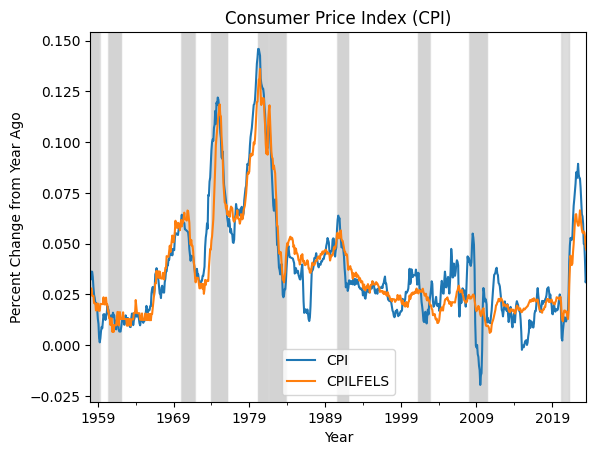

In [3]:
# INFLATION
%matplotlib inline
import pandas as pd
import pandas_datareader as web

# Import the data
start_date = "1947-01-01"
end_date = "2024-06-30"
PCI = pd.DataFrame(dict(
    CPI = web.DataReader("CPIAUCSL", "fred", start_date, end_date)["CPIAUCSL"],
    CPILFELS = web.DataReader("CPILFESL", "fred", start_date, end_date)['CPILFESL']
)).fillna(method="ffill").pct_change(12).dropna()

# Define the recession periods
recession_dates = web.DataReader("USREC", "fred", start_date, end_date)

# Plot the line chart
# Plot the line chart
fig, ax = plt.subplots()
PCI.plot(ax=ax)

# Add the recession rectangles
for start_date, recession in zip(recession_dates.index, recession_dates["USREC"]):
    if recession == 1:
        ax.axvspan(start_date, start_date + pd.Timedelta(days=365), color="lightgray", alpha=0.5)

# Add a title and labels
ax.set_title("Consumer Price Index (CPI)")
ax.set_xlabel("Year")
ax.set_ylabel("Percent Change from Year Ago")

# Show the plot
plt.show()

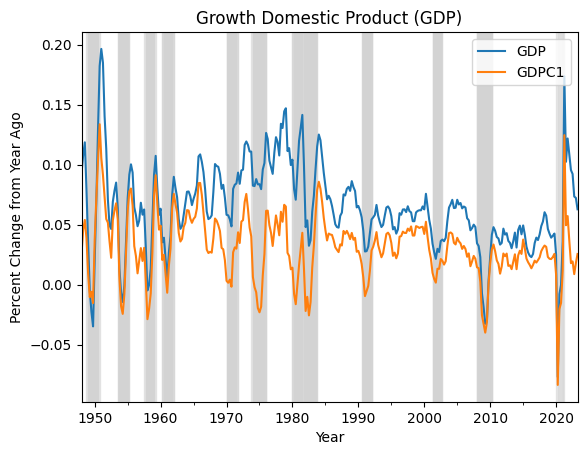

In [4]:
# GDP
%matplotlib inline
import pandas as pd
import pandas_datareader as web

# Import the data
start_date = "1947-01-01"
end_date = "2024-06-30"
GDP = pd.DataFrame(dict(
    GDP = web.DataReader("GDP", "fred", start_date, end_date)["GDP"],
    GDPC1 = web.DataReader("GDPC1", "fred", start_date, end_date)['GDPC1']
)).fillna(method="ffill").pct_change(4).dropna()

# Define the recession periods
recession_dates = web.DataReader("USREC", "fred", start_date, end_date)

# Plot the line chart
# Plot the line chart
fig, ax = plt.subplots()
GDP.plot(ax=ax)

# Add the recession rectangles
for start_date, recession in zip(recession_dates.index, recession_dates["USREC"]):
    if recession == 1:
        ax.axvspan(start_date, start_date + pd.Timedelta(days=365), color="lightgray", alpha=0.5)

# Add a title and labels
ax.set_title("Growth Domestic Product (GDP)")
ax.set_xlabel("Year")
ax.set_ylabel("Percent Change from Year Ago")

# Show the plot
plt.show()

In [5]:
# Define the start and end date for the analysis

start_date = "1959-01-01"
end_date = "2024-01-01"

signals = pd.DataFrame(dict(GDP = web.DataReader("GDPC1", "fred", start_date, end_date)['GDPC1'],CPI = web.DataReader("CPILFESL", "fred", start_date, end_date)['CPILFESL'])).fillna(method='ffill').pct_change(12).dropna()
prices = yf.download(['IYC','IDU','IYZ','IYW','IYJ','IYH','IYF','IYE','IYK','IYM','IYR','IVV','GLD','TIP','EMB','LQD','SHY','TLT'],"2001-01-01",end = end_date)['Adj Close']
#prices = prices.multiply(yf.download(['USDEUR=X'],'2010-01-04',end = end_date)['Close'],axis="index").dropna()

signals['GDP'] = signals['GDP'].shift(3)
signals['CPI'] = signals['CPI'].shift(1)
signals.dropna(inplace= True)

[*********************100%***********************]  18 of 18 completed


In [6]:
def InvestmentClockFixed(x,cuts={'GDP':0.025,'CPI':.03}):

   x_ = x.copy().assign(Growth=None,Inflation=None,Theme=None)

   # define high and low growth
   x_.loc[x['GDP']<=cuts['GDP'],'Growth'] = 'low'
   x_.loc[x['GDP']>cuts['GDP'],'Growth'] = 'high'

   # define high and low inflation
   x_.loc[x['CPI']<=cuts['CPI'],'Inflation'] = 'low'
   x_.loc[x['CPI']>cuts['CPI'],'Inflation'] = 'high'

   # define investment clock phases
   x_.loc[(x_.Growth=='low')&(x_.Inflation=='low'),'Theme'] = 'Reflection'
   x_.loc[(x_.Growth=='high')&(x_.Inflation=='low'),'Theme'] = 'Recovery'
   x_.loc[(x_.Growth=='high')&(x_.Inflation=='high'),'Theme'] = 'Overheat'
   x_.loc[(x_.Growth=='low')&(x_.Inflation=='high'),'Theme'] = 'Stagflation'
   return x_.dropna()

<Figure size 1200x1600 with 0 Axes>

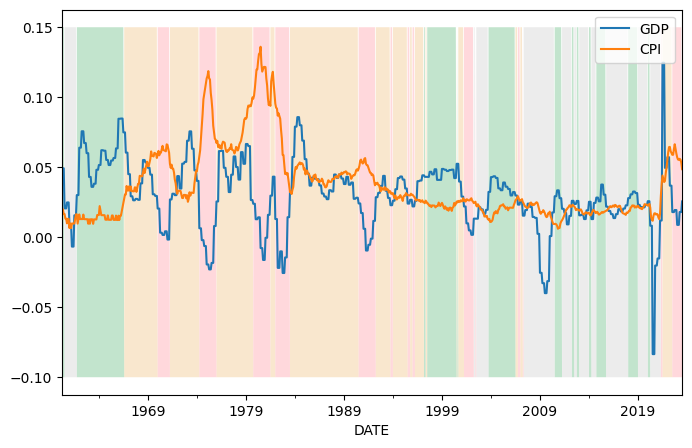

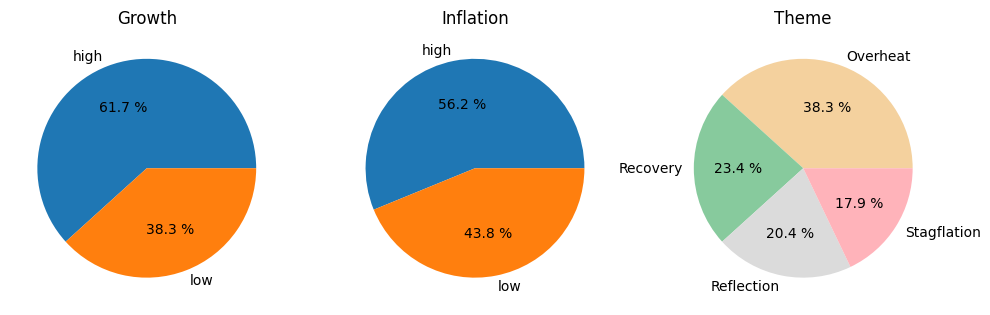

In [7]:
themes = InvestmentClockFixed(signals, cuts={'GDP':0.025,'CPI':0.025})
fig = plt.figure(figsize=(12,16))

fig.suptitle('Investment Clock Themes with Fixed Cuts',fontsize=16)
y_lim = (-.1,.15)
colors = dict(
  Overheat='#f4d19e',
  Recovery='#87ca9d',
  Reflection='#dbdbdb',
  Stagflation='#ffb3ba'
)
fig = themes[['GDP','CPI']].plot(figsize=(8,5))
for t in ['Overheat','Recovery','Reflection','Stagflation']:
   fig.fill_between(
      themes.index, y_lim[0],y_lim[1],
      where=(themes.Theme==t),
      interpolate = True,
      facecolor=colors[t],
      alpha = 0.5
   )

fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, nrows=1, figsize=(12, 16))
growth_counts=themes.Growth.value_counts()
ax2.pie(growth_counts,autopct='%.1f %%',
        labels=growth_counts.index)
ax2.set_title('Growth')
inflation_counts=themes.Inflation.value_counts()
ax3.pie(inflation_counts,autopct='%.1f %%',
        labels=inflation_counts.index)
ax3.set_title('Inflation')
theme_counts=themes.Theme.value_counts().sort_index(ascending=True)
ax4.pie(theme_counts,autopct='%.1f %%',
        labels=theme_counts.index,colors=colors.values())
ax4.set_title('Theme')
plt.show()

In [8]:
def drawdown(portfolio_returns: pd.DataFrame) -> pd.Series:
    """
    Calculates the drawdown with a rolling window of 1 year for the given portfolio returns.

    Args:
        portfolio_returns: A pandas dataframe with portfolio returns as values and dates as index.

    Returns:
        A pandas series with the drawdown values for each date in the input dataframe.
    """
    # Calculate the cumulative returns for the portfolio
    cum_returns = (1 + portfolio_returns).cumprod()

    # Calculate the rolling maximum of the cumulative returns over a 1-year window
    rolling_max = cum_returns.rolling(window='730D', min_periods=1).max()

    # Calculate the drawdown as the percentage difference between the rolling maximum and the cumulative returns
    drawdown = (cum_returns - rolling_max) / rolling_max

    # Return the drawdown as a pandas series with the same index as the input dataframe
    return drawdown.min()


def calculate_performance_metrics(portret,name):

    returns = portret.copy().dropna(axis=0)
    returns.columns = [str(name)]
    cumulative_returns = (1 + returns).cumprod() - 1
    annual_returns = (1 + returns).prod() ** (252 / len(returns)) - 1
    sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
    max_dd = drawdown(returns)
    #max_dd = (cumulative_returns - cumulative_returns.cummax()).min()
    calmar_ratio = annual_returns / abs(max_dd)

    performance_metrics = pd.DataFrame({
        #"CumulativeReturns": cumulative_returns.values[-1],
        "AnnualizedReturns": annual_returns[-1],
        "SharpeRatio": sharpe_ratio[-1],
        "MaxDrawdown": max_dd[-1],
        "CalmarRatio": calmar_ratio[-1]
    },index=[str(name)])

    #(returns + 1).cumprod().plot(label=str(name))

    return performance_metrics



In [9]:
#### Statitic Allweather vs Permanent

def permanent(prices,themes):

    returns = prices.pct_change()[1:]
    returns_regime = returns.reset_index().merge(themes, how='left',
                left_on=returns.index.to_period('M'),
                right_on=themes.index.to_period('M')).set_index('Date').fillna(method='ffill').drop(['key_0'],axis=1)

    # Initialize weights
    weights = pd.DataFrame(0, index=returns.index, columns=returns.columns)

    # Conditions to set weights based on the regime
    condition_reflection = returns_regime['Theme'] == 'Reflection'
    condition_recovery = returns_regime['Theme'] == 'Recovery'
    condition_overheat = returns_regime['Theme'] == 'Overheat'
    condition_stagflation = returns_regime['Theme'] == 'Stagflation'

    # Set the weights based on the conditions
    weights.loc[condition_reflection, ['SHY','GLD','TLT','IVV']] = [.25,.25,.25,.25]
    weights.loc[condition_recovery, ['SHY','GLD','TLT','IVV']] = [.25,.25,.25,.25]
    weights.loc[condition_overheat, ['SHY','GLD','TLT','IVV']] = [.25,.25,.25,.25]
    weights.loc[condition_stagflation,['SHY','GLD','TLT','IVV']] = [.25,.25,.25,.25]

    # Forward fill the weights
    weights.ffill(inplace=True)

    # Calculate portfolio returns and return the results
    portret = pd.DataFrame({'pret': np.diag((returns.fillna(0).values @ weights.values.T))}, index=weights.index)
    return portret, returns.fillna(0), weights


def allweather(prices,themes):

    returns = prices.pct_change()[1:]
    returns_regime = returns.reset_index().merge(themes, how='left',
                left_on=returns.index.to_period('M'),
                right_on=themes.index.to_period('M')).set_index('Date').fillna(method='ffill').drop(['key_0'],axis=1)

    # Initialize weights
    weights = pd.DataFrame(0, index=returns.index, columns=returns.columns)

    # Conditions to set weights based on the regime
    condition_reflection = returns_regime['Theme'] == 'Reflection'
    condition_recovery = returns_regime['Theme'] == 'Recovery'
    condition_overheat = returns_regime['Theme'] == 'Overheat'
    condition_stagflation = returns_regime['Theme'] == 'Stagflation'

    # Set the weights based on the conditions
    weights.loc[condition_reflection, ['LQD','EMB','GLD','TLT','TIP','IVV']] = [.06,.13,.15,.25,.21,.20]
    weights.loc[condition_recovery, ['LQD','EMB','GLD','TLT','TIP','IVV']] = [.06,.13,.15,.25,.21,.20]
    weights.loc[condition_overheat, ['LQD','EMB','GLD','TLT','TIP','IVV']] = [.06,.13,.15,.25,.21,.20]
    weights.loc[condition_stagflation,['LQD','EMB','GLD','TLT','TIP','IVV']] = [.06,.13,.15,.25,.21,.20]

    # Forward fill the weights
    weights.ffill(inplace=True)

    # Calculate portfolio returns and return the results
    portret = pd.DataFrame({'pret': np.diag((returns.fillna(0).values @ weights.values.T))}, index=weights.index)
    return portret, returns.fillna(0), weights

[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  1 of 1 completed


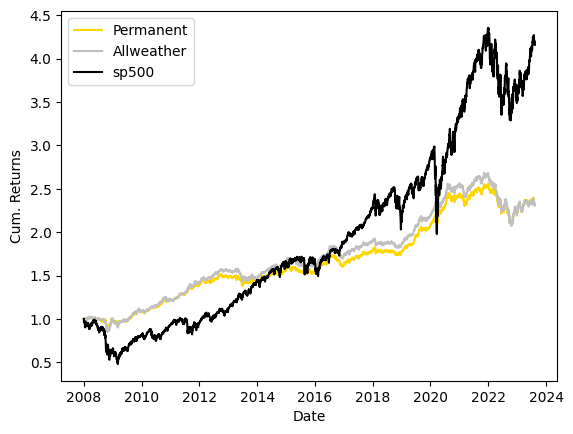

,AnnualizedReturns,SharpeRatio,MaxDrawdown,CalmarRatio
sp500,0.095725,0.548351,-0.518505,0.184617
allweather,0.055152,0.747287,-0.228614,0.241247
perm,0.055573,0.765303,-0.185489,0.299603


In [10]:
#### Test Static Portfolio

#### Enter Data Shifting the data considering real data gathering

start_date = "1959-01-01"
end_date = "2024-01-01"
signals = pd.DataFrame(dict(GDP = web.DataReader("GDPC1", "fred", start_date, end_date)['GDPC1'],CPI = web.DataReader("CPILFESL", "fred", start_date, end_date)['CPILFESL'])).fillna(method='ffill').pct_change(12).dropna()
prices = yf.download(['IYC','IDU','IYZ','IYW','IYJ','IYH','IYF','IYE','IYK','IYM','IYR','IVV','GLD','TIP','EMB','LQD','SHY','TLT','DBA','HYG'],"2008-01-01",end = end_date)['Adj Close']

signals['GDP'] = signals['GDP'].shift(3)
signals['CPI'] = signals['CPI'].shift(1)
signals.dropna(inplace= True)

#### Portfolio Calculation and testing

themes = InvestmentClockFixed(signals, cuts={'GDP':0.025,'CPI':0.03})
portretps, returnsps, weightsps = permanent(prices,themes=themes)
portreta, returnsa, weightsa = allweather(prices,themes=themes)

dfer = pd.DataFrame(columns= ['AnnualizedReturns',	'SharpeRatio',	'MaxDrawdown',	'CalmarRatio'])

sp500 = yf.download('SPY', start='2008-01-01',end=end_date).pct_change().dropna().drop(["Open","High","Low",'Close',"Volume"],axis=1)
dfer = pd.concat([dfer, calculate_performance_metrics(sp500,'sp500')], ignore_index=False)

dfer = pd.concat([dfer,calculate_performance_metrics(portreta,'allweather')], ignore_index=False)
dfer = pd.concat([dfer,calculate_performance_metrics(portretps,'perm')], ignore_index=False)


plt.plot(portretps.index, (portretps.pret+1).cumprod(), color='gold', label='Permanent')
plt.plot(portreta.index, (portreta.pret+1).cumprod(), color='silver', label='Allweather')
plt.plot(sp500.index, (sp500+1).cumprod(), color='Black', label='sp500')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Date")
plt.ylabel("Cum. Returns")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

dfer

In [11]:
####Dynamic Economic Rgime

def economicregimeEquity(prices,themes):

    returns = prices.pct_change()[1:]
    returns_regime = returns.reset_index().merge(themes, how='left',
                left_on=returns.index.to_period('M'),
                right_on=themes.index.to_period('M')).set_index('Date').fillna(method='ffill').drop(['key_0'],axis=1)

    # Initialize weights
    weights = pd.DataFrame(0, index=returns.index, columns=returns.columns)

    # Conditions to set weights based on the regime
    condition_reflection = returns_regime['Theme'] == 'Reflection'
    condition_recovery = returns_regime['Theme'] == 'Recovery'
    condition_overheat = returns_regime['Theme'] == 'Overheat'
    condition_stagflation = returns_regime['Theme'] == 'Stagflation'

    # Set the weights based on the conditions
    weights.loc[condition_reflection, ['IYF','IYH','IYK','IYC']] = [.25,.25,.25,.25]
    weights.loc[condition_recovery, ['IYZ','IYW','IYM','IYC']] = [.25,.25,.25,.25]
    weights.loc[condition_overheat, ['IYJ','IYW','IYM','IYE']] = [.25,.25,.25,.25]
    weights.loc[condition_stagflation,['IDU','IYH','IYK','IYE']] = [.25,.25,.25,.25]

    # Forward fill the weights
    weights.ffill(inplace=True)

    # Calculate portfolio returns and return the results
    portret = pd.DataFrame({'pret': np.diag((returns.fillna(0).values @ weights.values.T))}, index=weights.index)
    return portret, returns.fillna(0), weights

def economicregimeperm(prices,themes):

    returns = prices.pct_change()[1:]
    returns_regime = returns.reset_index().merge(themes, how='left',
                left_on=returns.index.to_period('M'),
                right_on=themes.index.to_period('M')).set_index('Date').fillna(method='ffill').drop(['key_0'],axis=1)

    # Initialize weights
    weights = pd.DataFrame(0, index=returns.index, columns=returns.columns)

    # Conditions to set weights based on the regime
    condition_reflection = returns_regime['Theme'] == 'Reflection'
    condition_recovery = returns_regime['Theme'] == 'Recovery'
    condition_overheat = returns_regime['Theme'] == 'Overheat'
    condition_stagflation = returns_regime['Theme'] == 'Stagflation'

    # Set the weights based on the conditions
    weights.loc[condition_reflection, ['SHY','TLT']] = [.5,.5]
    weights.loc[condition_recovery, ['IVV','TLT']] = [.5,.5]
    weights.loc[condition_overheat, ['IVV','GLD']] = [.5,.5]
    weights.loc[condition_stagflation,['TIP','GLD']] = [.5,.5]

    # Forward fill the weights
    weights.ffill(inplace=True)

    # Calculate portfolio returns and return the results
    portret = pd.DataFrame({'pret': np.diag((returns.fillna(0).values @ weights.values.T))}, index=weights.index)
    return portret, returns.fillna(0), weights


def economicregimeallweather(prices,themes):

    returns = prices.pct_change()[1:]
    returns_regime = returns.reset_index().merge(themes, how='left',
                left_on=returns.index.to_period('M'),
                right_on=themes.index.to_period('M')).set_index('Date').fillna(method='ffill').drop(['key_0'],axis=1)

    # Initialize weights
    weights = pd.DataFrame(0, index=returns.index, columns=returns.columns)

    # Conditions to set weights based on the regime
    condition_reflection = returns_regime['Theme'] == 'Reflection'
    condition_recovery = returns_regime['Theme'] == 'Recovery'
    condition_overheat = returns_regime['Theme'] == 'Overheat'
    condition_stagflation = returns_regime['Theme'] == 'Stagflation'

    # Set the weights based on the conditions
    weights.loc[condition_reflection, ['IVV', 'TLT','TIP']] = [.25, .5, .25]
    weights.loc[condition_recovery, ['IVV', 'GLD', 'EMB','LQD','TLT']] = [.375, .125, .125, .125,.25]
    weights.loc[condition_overheat, ['IVV', 'GLD', 'EMB','LQD','TIP']] = [.125, .291, .291, .125,.166]
    weights.loc[condition_stagflation, ['GLD', 'EMB','TLT','TIP']] = [.166, .166, .25, .416]

    # Forward fill the weights
    weights.ffill(inplace=True)

    # Calculate portfolio returns and return the results
    portret = pd.DataFrame({'pret': np.diag((returns.fillna(0).values @ weights.values.T))}, index=weights.index)
    return portret, returns.fillna(0), weights



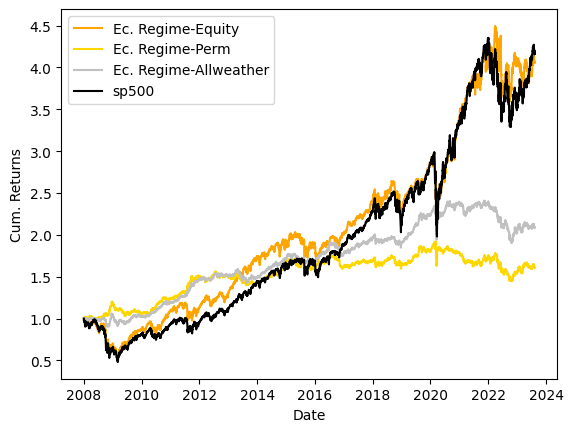

,AnnualizedReturns,SharpeRatio,MaxDrawdown,CalmarRatio
sp500,0.095725,0.548351,-0.518505,0.184617
allweather,0.055152,0.747287,-0.228614,0.241247
perm,0.055573,0.765303,-0.185489,0.299603
Ec. Regime-Equity,0.093918,0.550253,-0.493739,0.190217
Ec. Regime-Perm,0.030741,0.389770,-0.207319,0.148279
Ec. Regime-Allweather,0.048255,0.601538,-0.209068,0.230811


In [12]:
####Diagnostic Dinamic portfolio

portretere, returnsere, weightsere = economicregimeEquity(prices,themes=themes)
portretaerp, returnserp, weightserp = economicregimeperm(prices,themes=themes)
portreteraw, returnseraw, weightseraw = economicregimeallweather(prices,themes=themes)

dfer = pd.concat([dfer,calculate_performance_metrics(portretere,'Ec. Regime-Equity')], ignore_index=False)
dfer = pd.concat([dfer,calculate_performance_metrics(portretaerp,'Ec. Regime-Perm')], ignore_index=False)
dfer = pd.concat([dfer,calculate_performance_metrics(portreteraw,'Ec. Regime-Allweather')], ignore_index=False)


plt.plot(portretere.index, (portretere.pret+1).cumprod(), color='orange', label='Ec. Regime-Equity')
plt.plot(portretaerp.index, (portretaerp.pret+1).cumprod(), color='gold', label='Ec. Regime-Perm')
plt.plot(portreteraw.index, (portreteraw+1).cumprod(), color='silver', label='Ec. Regime-Allweather')
plt.plot(sp500.index, (sp500+1).cumprod(), color='Black', label='sp500')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Date")
plt.ylabel("Cum. Returns")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

dfer

In [13]:
returns = prices.pct_change()[1:]
returns_regime = returns.reset_index().merge(themes, how='left',
                left_on=returns.index.to_period('M'),
                right_on=themes.index.to_period('M')).set_index('Date').fillna(method='ffill').drop(['key_0'],axis=1)

condition_reflection = returns_regime['Theme'] == 'Reflection'
condition_recovery = returns_regime['Theme'] == 'Recovery'
condition_overheat = returns_regime['Theme'] == 'Overheat'
condition_stagflation = returns_regime['Theme'] == 'Stagflation'



In [14]:
import numpy as np
import itertools

#weights inizialization
weights_df = returns.copy()
for col in weights_df.columns:
    weights_df[col].values[:] = 0

#comb storage initialization
combinations_df = pd.DataFrame(data=None, index=None, columns=['DBA','EMB','GLD','HYG','IDU','IVV','IYC','IYE','IYF','IYH','IYJ','IYK','IYM','IYR','IYW','IYZ,','LQD','SHY','TIP','TLT','theme','return'], dtype=None, copy=False)

# Funzione di obiettivo da massimizzare
def objective(weights, returns):
    return ((asset_returns * weights).sum(axis=1)+1).cumprod()[-1]

# Genera tutte le possibili combinazioni di pesi
def generate_weights(n):
    # Genera i pesi in incrementi di 0.1
    increments = np.arange(0, 1.1, 0.1)

    # Ottieni tutte le possibili combinazioni di pesi
    combinations = list(itertools.product(increments, repeat=n))

    # Filtra solo le combinazioni di pesi che sommano a 1
    combinations = [weights for weights in combinations if np.sum(weights) == 1 and np.count_nonzero(weights) >= 2 and all(val >= 0.2 or val == 0 for val in weights) ]

    return combinations


# Ottimizzazione per ogni regime economico
for condition, assets, th in zip([condition_reflection, condition_recovery, condition_overheat, condition_stagflation],
                             #[['IYF', 'IYH', 'IYK', 'TLT', 'SHY', 'TIP'],
                              #['IYW', 'IYM', 'IYC', 'EMB', 'LQD', 'DBA'],
                              #['IYJ', 'IYW', 'IYM', 'IYE', 'EMB', 'TIP', 'DBA'],
                              #['GLD', 'DBA', 'SHY', 'TIP']]):
                              #[['IVV', 'SHY', 'TLT','GLD'],
                              #['IVV', 'SHY', 'TLT','GLD'],
                              #['IVV', 'SHY', 'TLT','GLD'],
                              #['IVV', 'SHY', 'TLT','GLD']],
                              [['IYW','IYH','IYK','TLT','GLD'],
                              ['IYW','IYC','IYH','TLT','IYR'],
                              ['IYW','IYK','IYE','IYM','IDU','GLD'],
                              ['IYR','IYH','IYE','IYW','GLD']],
                             ['refl','rec','over','stag']):


    # Ottieni i rendimenti per gli asset specifici del regime economico
    asset_returns = returns.loc[condition, assets]

    # Genera tutte le possibili combinazioni di pesi
    combinations = generate_weights(len(assets))

    # Trova la combinazione di pesi che massimizza il ritorno del portafoglio
    best_return = -np.inf
    best_weights = None
    for weights in combinations:
        port_return = objective(weights, asset_returns)
        if port_return > best_return:
            best_return = port_return
            best_weights = weights

        # Aggiunge la combinazione di pesi e il ritorno del portafoglio al dataframe combinations_df
        temp_df = pd.DataFrame([list(weights) + [th, port_return]], columns=assets+['theme','return'])
        combinations_df = pd.concat([combinations_df,temp_df], axis=0,ignore_index=True)

    # Imposta i pesi ottimizzati per le attività del regime economico
    weights_df.loc[condition, assets] = best_weights


In [15]:
top5_per_theme = combinations_df.groupby('theme').apply(lambda x: x.nlargest(5, 'return')).reset_index(drop=True)

df3 = weights_df.merge(returns_regime[['Theme']],left_index=True,right_index=True).drop_duplicates()
zero_cols = df3.columns[(df3 == 0).all()]
df3.drop(labels=zero_cols, axis=1)

,IDU,IYE,IYH,IYK,IYW,TLT,Theme
Date,,,,,,,
2008-01-03,0.0,0.0,0.0,0.2,0.8,0.0,Reflection
2010-07-01,0.0,0.0,0.2,0.0,0.0,0.8,Recovery
2021-06-01,0.0,0.2,0.0,0.0,0.8,0.0,Stagflation
2021-07-01,0.2,0.8,0.0,0.0,0.0,0.0,Overheat


In [16]:
#Creation of custom allocation

def economicregimepermcust(prices,themes):

    returns = prices.pct_change()[1:]
    returns_regime = returns.reset_index().merge(themes, how='left',
                left_on=returns.index.to_period('M'),
                right_on=themes.index.to_period('M')).set_index('Date').fillna(method='ffill').drop(['key_0'],axis=1)

    # Initialize weights
    weights = pd.DataFrame(0, index=returns.index, columns=returns.columns)

    # Conditions to set weights based on the regime
    condition_reflection = returns_regime['Theme'] == 'Reflection'
    condition_recovery = returns_regime['Theme'] == 'Recovery'
    condition_overheat = returns_regime['Theme'] == 'Overheat'
    condition_stagflation = returns_regime['Theme'] == 'Stagflation'

    # Set the weights based on the conditions
    weights.loc[condition_reflection, ['GLD','IVV','SHY','TLT']] = [.2,.8,0,0]
    weights.loc[condition_recovery, ['GLD','IVV','SHY','TLT']] = [0,0.2,0,0.8]
    weights.loc[condition_overheat, ['GLD','IVV','SHY','TLT']] = [0,0.8,0.2,0]
    weights.loc[condition_stagflation, ['GLD','IVV','SHY','TLT']] = [0.8,0,0.2,0]

    # Forward fill the weights
    weights.ffill(inplace=True)

    # Calculate portfolio returns and return the results
    portret = pd.DataFrame({'pret': np.diag((returns.fillna(0).values @ weights.values.T))}, index=weights.index)
    return portret, returns.fillna(0), weights

def economicregimeallweathercust(prices,themes):

    returns = prices.pct_change()[1:]
    returns_regime = returns.reset_index().merge(themes, how='left',
                left_on=returns.index.to_period('M'),
                right_on=themes.index.to_period('M')).set_index('Date').fillna(method='ffill').drop(['key_0'],axis=1)

    # Initialize weights
    weights = pd.DataFrame(0, index=returns.index, columns=returns.columns)

    # Conditions to set weights based on the regime
    condition_reflection = returns_regime['Theme'] == 'Reflection'
    condition_recovery = returns_regime['Theme'] == 'Recovery'
    condition_overheat = returns_regime['Theme'] == 'Overheat'
    condition_stagflation = returns_regime['Theme'] == 'Stagflation'

    # Set the weights based on the conditions
    weights.loc[condition_reflection, ['IYW','IYH','IYK']] = [.8,0,.2]
    weights.loc[condition_recovery, ['IYW','IYH','IYM','TLT','HYG']] = [0,.2,0,.8,0]
    weights.loc[condition_overheat, ['IYW','IDU','IYE','IYM','TIP','GLD']] = [0,.2,.8,0,0,0]
    weights.loc[condition_stagflation, ['IDU','IYW','IYE','IYK','TIP','GLD']] = [0,0.8,.2,0,0,0]

    # Forward fill the weights
    weights.ffill(inplace=True)

    # Calculate portfolio returns and return the results
    portret = pd.DataFrame({'pret': np.diag((returns.fillna(0).values @ weights.values.T))}, index=weights.index)
    return portret, returns.fillna(0), weights


def economicregimeallweathercustdiff(prices,themes):

    returns = prices.pct_change()[1:]
    returns_regime = returns.reset_index().merge(themes, how='left',
                left_on=returns.index.to_period('M'),
                right_on=themes.index.to_period('M')).set_index('Date').fillna(method='ffill').drop(['key_0'],axis=1)

    # Initialize weights
    weights = pd.DataFrame(0, index=returns.index, columns=returns.columns)

    # Conditions to set weights based on the regime
    condition_reflection = returns_regime['Theme'] == 'Reflection'
    condition_recovery = returns_regime['Theme'] == 'Recovery'
    condition_overheat = returns_regime['Theme'] == 'Overheat'
    condition_stagflation = returns_regime['Theme'] == 'Stagflation'

    # Set the weights based on the conditions
    weights.loc[condition_reflection, ['IYW','IYH','IYK']] = [.6,.2,.2]
    weights.loc[condition_recovery, ['IYW','IYC','IYM','TLT','IYH']] = [0,.2,0,.6,0.2]
    weights.loc[condition_overheat, ['IYW','IYH','IYE','IYM','IYK','IDU']] = [0,0,.6,0,.2,.2]
    weights.loc[condition_stagflation, ['IYW','IYH','IYE','IYK','TIP','GLD']] = [.6,0,.2,.2,0,0]

    # Forward fill the weights
    weights.ffill(inplace=True)

    # Calculate portfolio returns and return the results
    portret = pd.DataFrame({'pret': np.diag((returns.fillna(0).values @ weights.values.T))}, index=weights.index)
    return portret, returns.fillna(0), weights


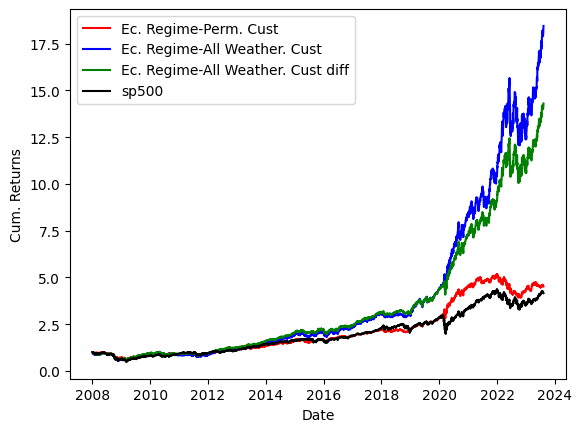

,AnnualizedReturns,SharpeRatio,MaxDrawdown,CalmarRatio
sp500,0.095725,0.548351,-0.518505,0.184617
allweather,0.055152,0.747287,-0.228614,0.241247
perm,0.055573,0.765303,-0.185489,0.299603
Ec. Regime-Equity,0.093918,0.550253,-0.493739,0.190217
Ec. Regime-Perm,0.030741,0.389770,-0.207319,0.148279
Ec. Regime-Allweather,0.048255,0.601538,-0.209068,0.230811
Ec. Regime-Perm. Cust,0.101525,0.704656,-0.425556,0.238571
Ec. Regime-All Weather. Cust,0.205575,1.036241,-0.472251,0.435308
Ec. Regime-All Weather. Cust Diff,0.186047,1.049311,-0.445310,0.417793


In [17]:
#### Portfolio Calculation and testing

themes = InvestmentClockFixed(signals, cuts={'GDP':0.025,'CPI':0.03})
portreterpc, returnserpc, weightserpc = economicregimepermcust(prices,themes=themes)
portreterawc, returnserawc, weightserawc = economicregimeallweathercust(prices,themes=themes)
portreterawcd, returnserawcd, weightserawcd = economicregimeallweathercustdiff(prices,themes=themes)



dfer = pd.concat([dfer,calculate_performance_metrics(portreterpc,'Ec. Regime-Perm. Cust')], ignore_index=False)
dfer = pd.concat([dfer,calculate_performance_metrics(portreterawc,'Ec. Regime-All Weather. Cust')], ignore_index=False)
dfer = pd.concat([dfer,calculate_performance_metrics(portreterawcd,'Ec. Regime-All Weather. Cust Diff')], ignore_index=False)


plt.plot(portreterpc.index, (portreterpc.pret+1).cumprod(), color='red', label='Ec. Regime-Perm. Cust')
plt.plot(portreterawc.index, (portreterawc.pret+1).cumprod(), color='blue', label='Ec. Regime-All Weather. Cust')
plt.plot(portreterawcd.index, (portreterawcd.pret+1).cumprod(), color='green', label='Ec. Regime-All Weather. Cust diff')
plt.plot(sp500.index, (sp500+1).cumprod(), color='Black', label='sp500')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Date")
plt.ylabel("Cum. Returns")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

dfer

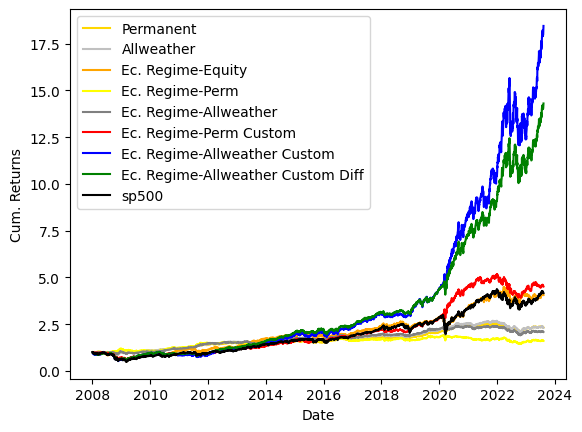

In [18]:
plt.plot(portretps.index, (portretps.pret+1).cumprod(), color='gold', label='Permanent')
plt.plot(portreta.index, (portreta.pret+1).cumprod(), color='silver', label='Allweather')
plt.plot(portretere.index, (portretere.pret+1).cumprod(), color='orange', label='Ec. Regime-Equity')
plt.plot(portretaerp.index, (portretaerp.pret+1).cumprod(), color='yellow', label='Ec. Regime-Perm')
plt.plot(portreteraw.index, (portreteraw+1).cumprod(), color='grey', label='Ec. Regime-Allweather')
plt.plot(portreterpc.index, (portreterpc.pret+1).cumprod(), color='red', label='Ec. Regime-Perm Custom')
plt.plot(portreterawc.index, (portreterawc.pret+1).cumprod(), color='blue', label='Ec. Regime-Allweather Custom')
plt.plot(portreterawcd.index, (portreterawcd.pret+1).cumprod(), color='green', label='Ec. Regime-Allweather Custom Diff')
plt.plot(sp500.index, (sp500+1).cumprod(), color='Black', label='sp500')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Date")
plt.ylabel("Cum. Returns")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

In [19]:
#### Plot Weights Allocations

import plotly.express as px
import pandas as pd

# Step 2: Retrieve data and convert to DataFrame
weightplot = weightserawcd.merge(returns_regime[['Theme']],left_index=True,right_index=True).drop_duplicates()
zero_cols = weightplot.columns[(weightplot == 0).all()]
df = weightplot.drop(labels=zero_cols, axis=1).set_index(['Theme'])
fig = px.bar(df, x=df.index, y=df.columns, barmode='stack')

# Step 4: Display the chart
fig.show()

weightplot = weightserawc.merge(returns_regime[['Theme']],left_index=True,right_index=True).drop_duplicates()
zero_cols = weightplot.columns[(weightplot == 0).all()]

df = weightplot.drop(labels=zero_cols, axis=1).set_index(['Theme'])



# Step 3: Create Plotly area chart
fig = px.bar(df, x=df.index, y=df.columns, barmode='stack')

# Step 4: Display the chart
fig.show()

In [20]:
returns = prices.resample('MS').last().pct_change()#[['DBA','EMB','GLD','IVV','LQD','SHY','TIP','TLT']]
returns_regime = returns.reset_index().merge(themes, how='left',
                left_on=returns.index.to_period('M'),
                right_on=themes.index.to_period('M')).set_index('Date').fillna(method='ffill').drop(['key_0'],axis=1)

returns_regime.groupby(['Growth','Inflation',"Theme"]).mean()

DBA       EMB       GLD       HYG  \
Growth Inflation Theme                                                 
high   high      Overheat     0.008016 -0.016253  0.001300 -0.008966   
       low       Recovery     0.001224 -0.001318  0.001334  0.000884   
low    high      Stagflation  0.003255  0.006326 -0.000248  0.007332   
       low       Reflection  -0.004536  0.007751  0.007093  0.006766   

                                   IDU       IVV       IYC       IYE  \
Growth Inflation Theme                                                 
high   high      Overheat     0.007851 -0.006467 -0.020297  0.033481   
       low       Recovery     0.006009  0.000604  0.005069 -0.016695   
low    high      Stagflation -0.001961  0.017074  0.021814  0.018921   
       low       Reflection   0.007231  0.013311  0.015147  0.010571   

                                   IYF       IYH  ...       IYM       IYR  \
Growth Inflation Theme                            ...                       
high   high      Overheat    -0.004503  0.001795  ... -0.003885 -0.004690   
       low       Recovery    -0.003312  0.005925  ... -0.006648  0.004157   
low    high      Stagflation  0.007402  0.006989  ...  0.008958  0.001417   
       low       Reflection   0.011221  0.012690  ...  0.013696  0.009667   

                                   IYW       IYZ       LQD       SHY  \
Growth Inflation Theme                                                 
high   high      Overheat    -0.014992 -0.015757 -0.013812 -0.002293   
       low       Recovery     0.001187 -0.001005  0.000998  0.001282   
low    high      Stagflation  0.033196 -0.005192  0.003910 -0.000067   
       low       Reflection   0.019353  0.007462  0.006229  0.001161   

                                   TIP       TLT       GDP       CPI  
Growth Inflation Theme                                                
high   high      Overheat    -0.004496 -0.019436  0.061119  0.051771  
       low       Recovery     0.001849  0.009087  0.029222  0.017452  
low    high      Stagflation -0.000279 -0.001691  0.015731  0.056948  
       low       Reflection   0.003612  0.004240  0.007340  0.019069  

[4 rows x 22 columns]

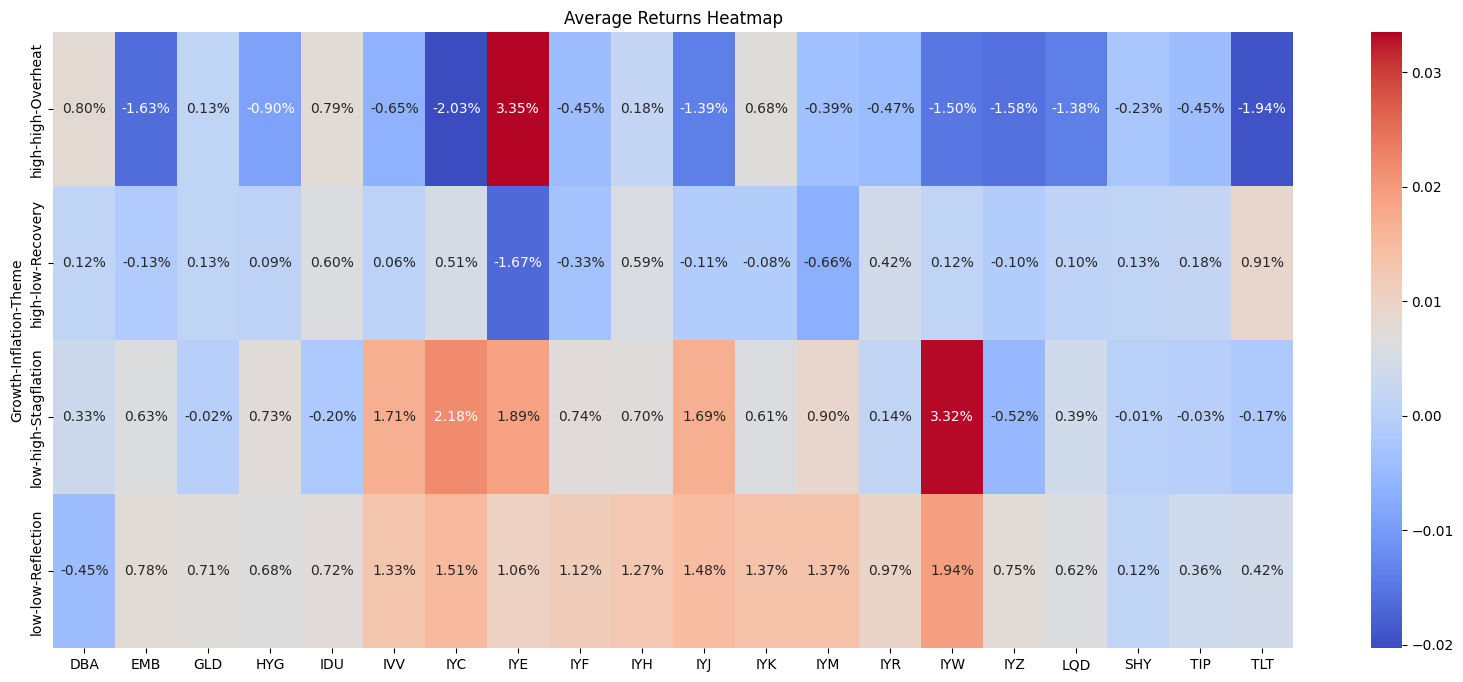

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the previous data processing is done
avg_returns = returns_regime.groupby(['Growth', 'Inflation', "Theme"]).mean().drop(['GDP','CPI'],axis=1)

# Create the heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(avg_returns, annot=True, cmap="coolwarm", fmt=".2%")
plt.title("Average Returns Heatmap")
plt.show()